In [6]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from tool.utils import load_runs, load_experiments_df, get_unique_experiments, get_single_experiment_runs, split_runs_df, train_regressor_model, evaluate_test_experiment_df
from tool.constants import *
from tool.tool import simulate_tool_usage
import pandas as pd
import numpy as np



In [7]:
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100  # 200 e.g. is really fine, but slower
# sns.set(rc={'figure.figsize':(10,4)})


## Tool Decisions

### Description of the reduction curve

$$y = c_1 + c_2*log(x)$$

In [8]:
ts_runs_df = load_runs('time_series')

experiments_df = pd.DataFrame()

for linear_regressor_name, linear_regressor in linear_regressors.items():
    experiments_df = pd.concat([
        experiments_df, 
        load_experiments_df(ts_runs_df, linear_regressor).assign(linear_regressor=linear_regressor_name)
    ])

unique_experiment_names = get_unique_experiments(ts_runs_df)


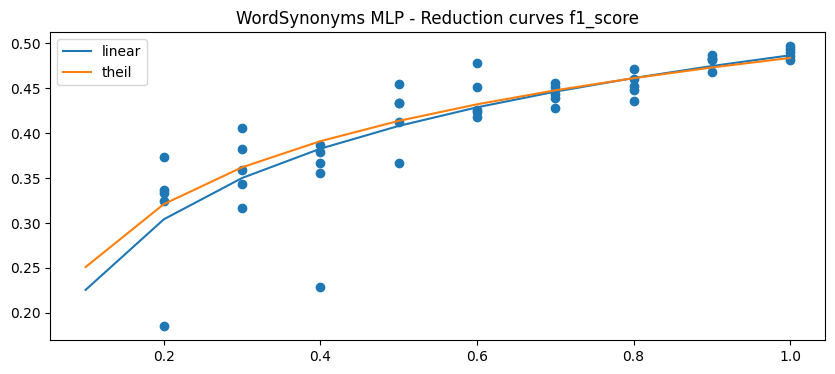

In [4]:
for dataset, model in unique_experiment_names[-2::-1]:
    metric = 'f1_score'
    experiment_runs = get_single_experiment_runs(ts_runs_df, model, dataset)
    experiment_reduction_curves_df = get_single_experiment_runs(experiments_df, model, dataset).query(f"metric == '{metric}'")
    X = np.arange(0.1, 1.1, 0.1)
    plt.title(f"{dataset} {model} - Reduction curves {metric}")
    plt.scatter(experiment_runs[['data_quality_dimension_percentage']], experiment_runs[[metric]])

    for i, reduction_curve in experiment_reduction_curves_df.iterrows():
        plt.plot(X, reduction_curve.intercept + reduction_curve.slope*np.log(X), label=f"{reduction_curve.linear_regressor}")
    
    plt.legend()
    plt.show()
    break
    


### Analysing Performance on different Regressor models

- The idea of the tool regressor is to estimate the curve coefficient of a new experiment (model, dataset) + metric, based on its characteristics
- The training set then would be the different experiments with respective curve coefficients

In [ ]:
# This block tests the different regression models, also can take a bit
results = []

ts_runs_df = load_runs('time_series')

for _ in tqdm(range(10)):
    linear_regressor = TheilSenRegressor
    train_ts_run_df, test_ts_run_df = split_runs_df(ts_runs_df, SPLIT_PERCENTAGE)
    train_ts_experiments_df, test_ts_experiments_df = load_experiments_df(
        train_ts_run_df, linear_regressor, ['f1_score']), load_experiments_df(
        test_ts_run_df, linear_regressor, ['f1_score'])

    for metric in ['f1_score']:  # METRICS
        for regressor_name, regressor in regressors.items():
            reg, enc = train_regressor_model(train_ts_experiments_df, metric, regressor,
                                             DATASET_ESTIMATORS_CAT, DATASET_ESTIMATORS_NUM)
            mse = evaluate_test_experiment_df(test_ts_experiments_df, metric, enc, reg,
                                              DATASET_ESTIMATORS_CAT, DATASET_ESTIMATORS_NUM)

            results.append({
                'regressor': regressor_name,
                'mse': mse,
                'metric': metric
            })


results = pd.DataFrame(results)
results.groupby('metric').boxplot(by=['regressor'], layout=(5, 1), figsize=(10, 20), column='mse')


## Evaluating the tool

In [42]:
results = []
hyper_search_iterations = 100000
linear_regressor = TheilSenRegressor
base_metric_result_percentage = 0.5
perf_goal_increases = [0.05, 0.1, 0.15]

for perf_goal_increase in perf_goal_increases:
    for _ in tqdm(range(5)):

        train_ts_run_df, test_ts_run_df = split_runs_df(ts_runs_df, SPLIT_PERCENTAGE)
        train_ts_experiments_df, test_ts_experiments_df = load_experiments_df(train_ts_run_df, linear_regressor, ['f1_score']), load_experiments_df(test_ts_run_df, linear_regressor, ['f1_score'])


        for sample in test_ts_experiments_df.iterrows():
            sample = sample[1]
            

            regressor = regressors['random_forest']
            result = simulate_tool_usage(ts_runs_df, train_ts_experiments_df, sample, regressor,
                                         hyper_search_iterations, False, base_metric_result_percentage, perf_goal_increase)
            results.append(result)
        
results_df = pd.DataFrame(results)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.27s/it]


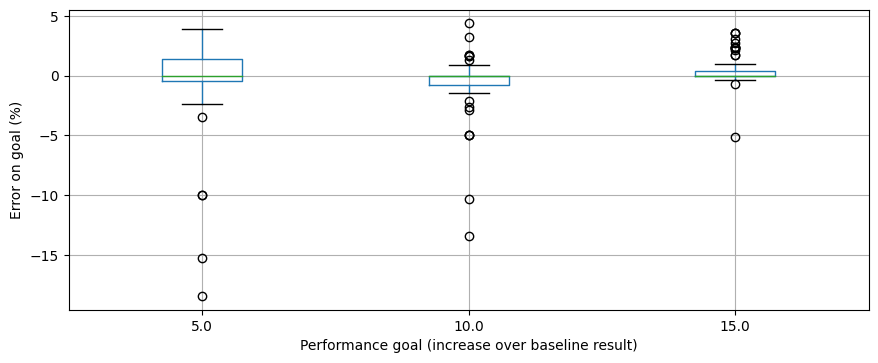

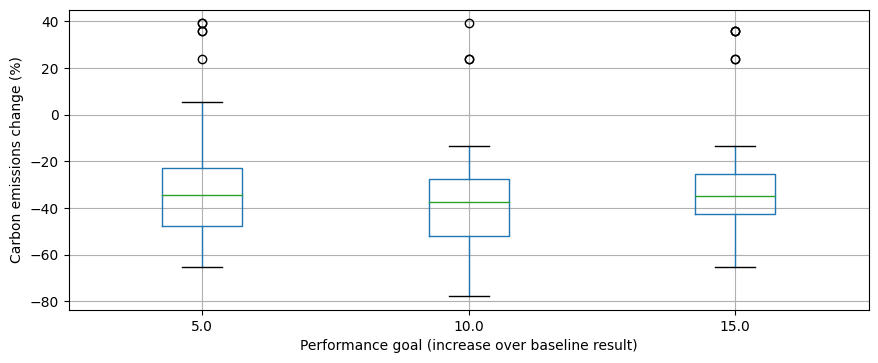

In [43]:
summary_columns = ['user_goal_error', 'emissions_percentual_change']


ax = results_df.boxplot(column=summary_columns[0], by=['performance_goal_increase'])
fig = ax.get_figure()
fig.suptitle('')
ax.set_title("")
ax.set_xlabel("Performance goal (increase over baseline result)")
ax.set_ylabel("Error on goal (%)")

plt.show()

ax = results_df.boxplot(column=summary_columns[1], by=['performance_goal_increase'])
fig = ax.get_figure()
fig.suptitle('')
ax.set_title("")
ax.set_xlabel("Performance goal (increase over baseline result)")
ax.set_ylabel("Carbon emissions change (%)")

plt.show()



In [44]:
results = []
hyper_search_iterations = 100
linear_regressor = TheilSenRegressor
base_metric_result_percentage = 0.5
perf_goal_increases = [0.05, 0.1, 0.15]

for perf_goal_increase in perf_goal_increases:
    for _ in tqdm(range(5)):

        train_ts_run_df, test_ts_run_df = split_runs_df(ts_runs_df, SPLIT_PERCENTAGE)
        train_ts_experiments_df, test_ts_experiments_df = load_experiments_df(train_ts_run_df, linear_regressor, ['f1_score']), load_experiments_df(test_ts_run_df, linear_regressor, ['f1_score'])


        for sample in test_ts_experiments_df.iterrows():
            sample = sample[1]
            

            regressor = regressors['random_forest']
            result = simulate_tool_usage(ts_runs_df, train_ts_experiments_df, sample, regressor,
                                         hyper_search_iterations, False, base_metric_result_percentage, perf_goal_increase)
            results.append(result)
        
        
results_df = pd.DataFrame(results)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.45s/it]


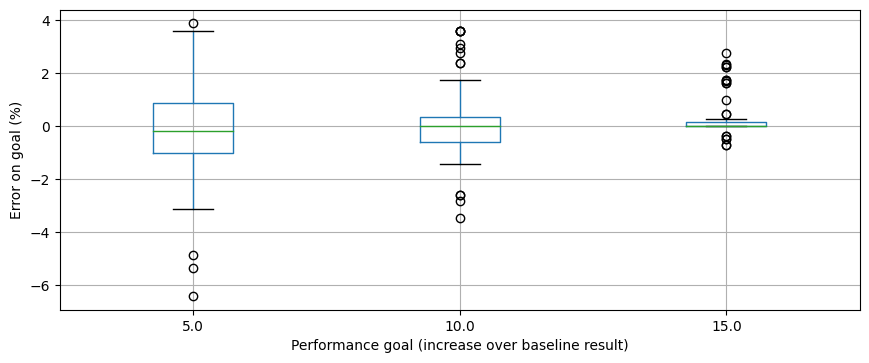

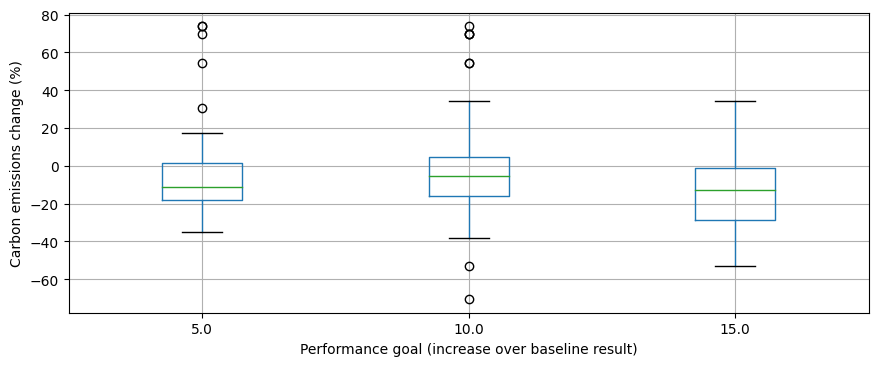

In [45]:
summary_columns = ['user_goal_error', 'emissions_percentual_change']


ax = results_df.boxplot(column=summary_columns[0], by=['performance_goal_increase'])
fig = ax.get_figure()
fig.suptitle('')
ax.set_title("")
ax.set_xlabel("Performance goal (increase over baseline result)")
ax.set_ylabel("Error on goal (%)")

plt.show()

ax = results_df.boxplot(column=summary_columns[1], by=['performance_goal_increase'])
fig = ax.get_figure()
fig.suptitle('')
ax.set_title("")
ax.set_xlabel("Performance goal (increase over baseline result)")
ax.set_ylabel("Carbon emissions change (%)")

plt.show()



In [17]:
full_emissions, base_emissions, tool_suggested_emissions = results_df[['full_experiment_kg_emissions','base_experiment_kg_emissions','tool_suggested_experiment_kg_emissions']].mean()

C:\Users\marti\AppData\Local\Temp\ipykernel_17176\1691310390.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(np.array(N, dtype='str'), rotation = 45)


[Text(0, 0, '16'),
 Text(1, 0, '32'),
 Text(2, 0, '64'),
 Text(3, 0, '128'),
 Text(4, 0, '256'),
 Text(5, 0, '512'),
 Text(6, 0, '1024'),
 Text(7, 0, '2048')]

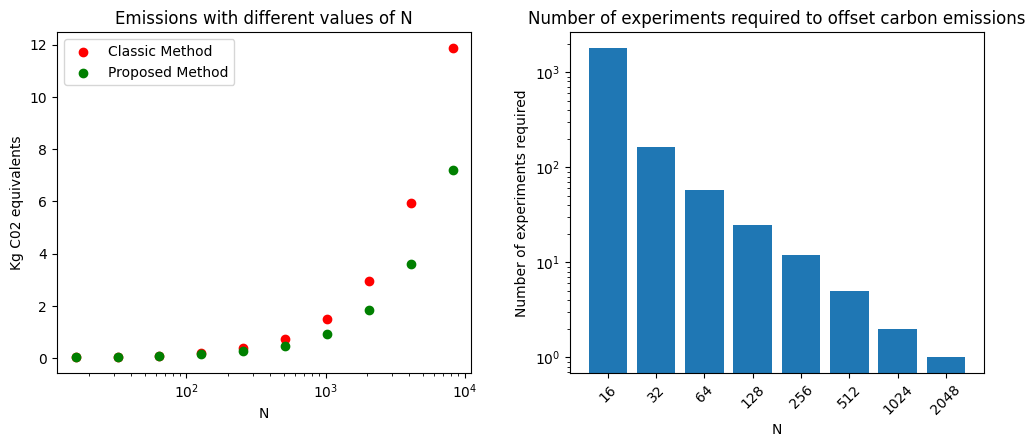

In [41]:
all_experiment_kg = 6.7
n = 25
def e(t):
    
    if t == 1:
        return full_emissions
    
    if t == 0.5:
        return base_emissions
    
    return tool_suggested_emissions

t_i = 0.5
N = 2**np.arange(4, 14)

# This number can be anything except for 1 and 0.5
t_f = 0.7 

classic_method_emissions = N*e(1)
our_method_emissions = N*e(t_i) + n*e(t_f)
percentual_change = (our_method_emissions - classic_method_emissions)/classic_method_emissions

saved_emissions = classic_method_emissions - our_method_emissions


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout(w_pad=4.0)
# fig.suptitle(f"Percentual Change Limit")

ax1.scatter(N, classic_method_emissions, c='r', label='Classic Method')
ax1.scatter(N, our_method_emissions, c='g', label='Proposed Method')
ax1.set_xscale('log')
ax1.set_title('Emissions with different values of N')
ax1.set_xlabel('N')
ax1.set_ylabel('Kg C02 equivalents')
ax1.legend()




needed_experiments = np.array(all_experiment_kg/saved_emissions, dtype=int)
filter_elements = needed_experiments > 0


needed_experiments = needed_experiments[filter_elements]

ax2.bar(np.array(N[filter_elements], dtype='str'), needed_experiments)
ax2.set_title('Number of experiments required to offset carbon emissions')
ax2.set_xlabel('N')
ax2.set_ylabel('Number of experiments required')
ax2.set_yscale('log')

start, end = ax2.get_ylim()
# ax2.yaxis.set_ticks(np.arange(-2, 6, 1))

ax2.set_xticklabels(np.array(N, dtype='str'), rotation = 45)